2024-05-03 22:32:19.645589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Connected to MySQL database
       match_id       team opposite_team               player  \
0    T20I # 448  Sri Lanka      Pakistan      Binura Fernando   
1   T20I # 1174  Sri Lanka       England      Binura Fernando   
2   T20I # 1458  Sri Lanka     Australia      Binura Fernando   
3   T20I # 2479  Sri Lanka   Afghanistan      Binura Fernando   
4    T20I # 461  Sri Lanka   West Indies  Dushmantha Chameera   
5    T20I # 515  Sri Lanka         India  Dushmantha Chameera   
6    T20I # 513  Sri Lanka    Bangladesh  Dushmantha Chameera   
7    T20I # 510  Sri Lanka        U.A.E.  Dushmantha Chameera   
8    T20I # 499  Sri Lanka         India  Dushmantha Chameera   
9    T20I # 497  Sri Lanka         India  Dushmantha Chameera   
10   T20I # 634  Sri Lanka         India  Dushmantha Chameera   
11   T20I # 633  Sri Lanka         India  Dushmantha Chameera   
12   T20I # 659  Sri Lanka         India  Dushmantha Chameera   
13  T20I # 1382  Sri Lanka       England  Dushmantha Chameera 

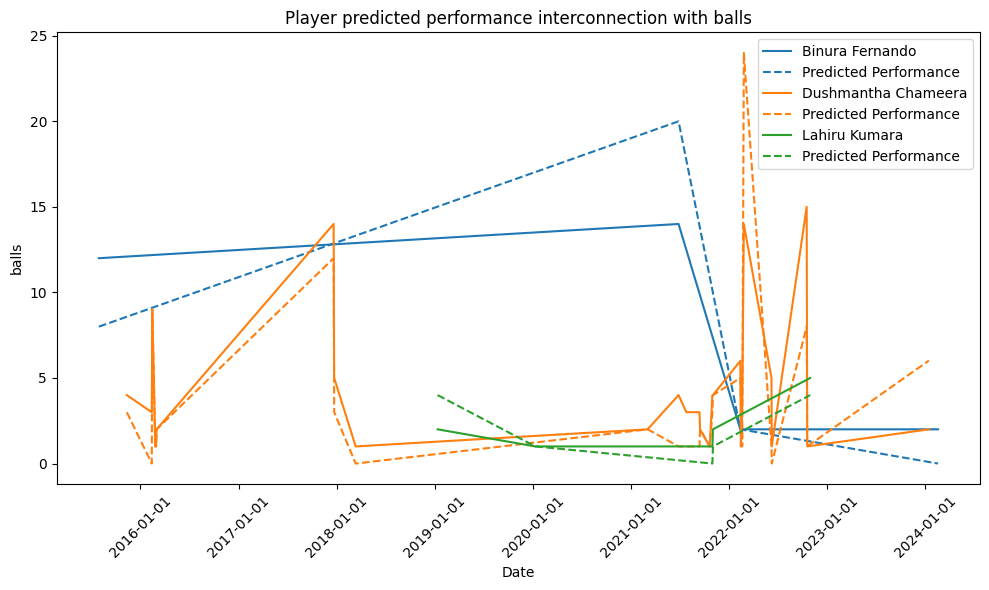

In [1]:
import mysql_connection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.impute import SimpleImputer
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt

def fetch_data(team, players):
    connection = mysql_connection.get_mysql_connection()

    if connection:
        dfs = []

        for player in players:
            if team == 'All' and player == 'All':
                sql_query = """
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.batting_position, b.dismissal_method, b.runs, b.balls, b.fours, b.sixes, b.strike_rate, m.ground, m.match_date
                FROM cricket_info.batting AS b
                JOIN cricket_info.matches AS m ON b.match_id = m.match_id
                WHERE b.batting_position != '-' AND (b.balls != '-' AND b.balls != '0');
                """
                cursor = connection.cursor()
                cursor.execute(sql_query)
            elif team == 'All':
                sql_query = """
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.batting_position, b.dismissal_method, b.runs, b.balls, b.fours, b.sixes, b.strike_rate, m.ground, m.match_date
                FROM cricket_info.batting AS b
                JOIN cricket_info.matches AS m ON b.match_id = m.match_id
                WHERE  b.batting_position != '-' AND b.player LIKE %s AND (b.balls != '-' AND b.balls != '0');
                """
                cursor = connection.cursor()
                cursor.execute(sql_query, (f'%{player}%',))
            else:
                sql_query = """
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.batting_position, b.dismissal_method, b.runs, b.balls, b.fours, b.sixes, b.strike_rate, m.ground, m.match_date
                FROM cricket_info.batting AS b
                JOIN cricket_info.matches AS m ON b.match_id = m.match_id
                WHERE b.batting_position != '-' AND  b.team = %s AND b.player LIKE %s AND (b.balls != '-' AND b.balls != '0') ;
                """
                cursor = connection.cursor()
                cursor.execute(sql_query, (team, f'%{player}%'))

           
            rows = cursor.fetchall()
            df = pd.DataFrame(rows, columns=['match_id', 'team', 'opposite_team', 'player', 'batting_position', 'dismissal_method', 'runs', 'balls', 'fours', 'sixes', 'strike_rate', 'ground', 'date'])
            dfs.append(df)
            cursor.close()

        connection.close()
        df = pd.concat(dfs, ignore_index=True)
        return df
    else:
        print("Connection to the database failed.")
        return None


# Function to convert string representation of overs to decimal
def convert_to_decimal(overs_str):
    if '.' in overs_str:
        overs, balls = overs_str.split('.')
        decimal_overs = float(overs) + float(balls) / 6
    else:
        decimal_overs = float(overs_str)
    return decimal_overs


# Function to calculate Bowling Average
def calculate_bowling_average(runs, wickets):
    if wickets == 0:
        return 0
    else:
        return runs / wickets


# Function to calculate Economy Rate
def calculate_economy_rate(runs, overs):
    if overs == 0:
        return 0
    else:
        return runs / overs


# Function to calculate Strike Rate
def calculate_strike_rate(overs, wickets):
    if wickets == 0:
        return 0
    else:
        return (overs * 6) / wickets


# Function to calculate Wicket-taking Ability (Wickets per Match)
def calculate_wickets_per_match(wickets, matches):
    if wickets == 0:
        return 0
    else:
        return wickets / matches


# Function to calculate Wicket-taking Ability (Wickets per Over)
def calculate_wickets_per_over(wickets, overs):
    if wickets == 0:
        return 0
    else:
        return wickets / overs
    
def calculate_dots_per_over(dot, overs):
    if dot == 0:
        return 0
    else:
        return dot / overs
    

def transform_data(df):
    # Preprocessing part starts here...
    df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y', errors='coerce')
    df['runs'] = pd.to_numeric(df['runs'], errors='coerce')
    df['balls'] = pd.to_numeric(df['balls'], errors='coerce')
    df['fours'] = pd.to_numeric(df['fours'], errors='coerce')
    df['sixes'] = pd.to_numeric(df['sixes'], errors='coerce')
    df['strike_rate'] = pd.to_numeric(df['strike_rate'], errors='coerce')
    
    try:
        df['day'] = df['date'].dt.day
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
    except ValueError:
        print("Dropping records with incorrect date format...")
        wrong_date_indices = df.index[(df['date'].dt.day.isna()) | (df['date'].dt.month.isna()) | (df['date'].dt.year.isna())]
        df.drop(wrong_date_indices, inplace=True)
        print(f"Dropped {len(wrong_date_indices)} records.")

    return df



# def plot_performance(plot_data_df, filter_field):
#     # Ensure filter_field is valid
#     if filter_field not in plot_data_df.columns:
#         print(f"Error: '{filter_field}' is not a valid field.")
#         return

#     # Sort the DataFrame by date
#     plot_data_df = plot_data_df.sort_values(by='date')
#     print("############")
#     print(plot_data_df)
#     # Plot the performance for each player on a single graph
#     plt.figure(figsize=(10, 6))

#     for player in plot_data_df['player'].unique():
#         player_records = plot_data_df[plot_data_df['player'] == player]
#         plt.plot(player_records['date'], player_records[filter_field], label=player)
#         plt.plot(player_records['date'], player_records['predicted_runs'], linestyle='--', color=plt.gca().lines[-1].get_color(), label='Predicted Performance')

#     plt.xlabel('Date')
#     plt.ylabel(filter_field)
#     plt.title(f"Player predicted performance interconnection with {filter_field}")
#     plt.legend()
#     plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#     plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis
#     plt.tight_layout()  # Adjust layout to prevent overlapping labels
    
#     # Save the figure with the specified title
#     plt.savefig(f"Player_predicted_batting_performance_interconnection_with_{filter_field}.png")
    
#     plt.show()



def plot_performance(plot_data_df, filter_field):
    # Ensure filter_field is valid
    if filter_field not in plot_data_df.columns:
        print(f"Error: '{filter_field}' is not a valid field.")
        return

    # Sort the DataFrame by date
    plot_data_df = plot_data_df.sort_values(by='date')

    # Plot the performance for each player on a single graph
    plt.figure(figsize=(10, 6))

    for player in plot_data_df['player'].unique():
        player_records = plot_data_df[plot_data_df['player'] == player]
        plt.plot(player_records['date'], player_records[filter_field], label=player)
        plt.plot(player_records['date'], player_records['predicted_runs'], linestyle='--', color=plt.gca().lines[-1].get_color(), label='Predicted Performance')

    plt.xlabel('Date')
    plt.ylabel(filter_field)
    plt.title(f"Player predicted performance interconnection with {filter_field}")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    
    # Save the figure with the specified title
    plt.savefig(f"Player_predicted_batting_performance_interconnection_with_{filter_field}.png")
    
    plt.show()


def plot_performance_chart_only(plot_data_df):
    # Sort the DataFrame by date
    plot_data_df = plot_data_df.sort_values(by='date')

    # Plot the predicted performance for each player on a single graph
    plt.figure(figsize=(10, 6))

    for player in plot_data_df['player'].unique():
        player_records = plot_data_df[plot_data_df['player'] == player]
        plt.plot(player_records['date'], player_records['predicted_runs'], linestyle='--', label=player)

    plt.xlabel('Date')
    plt.ylabel('Predicted Performance')
    plt.title("Player Predicted Batting Performance")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    
    # Save the figure with the specified title
    plt.savefig("Player_predicted_batting_performance.png")
    
    plt.show()


def predict_batting_performance(selected_players_data):
    # Load the trained Random Forest Regression model
    random_forest_model = joblib.load("random_forest_regressor_model_batting.pkl")
    
    # Extract features for the selected players
    selected_players_features = selected_players_data[['team', 'opposite_team', 'dismissal_method', 'balls', 'fours', 'sixes', 'strike_rate', 'ground', 'day', 'month', 'year']]
    
    # Predict the performance of each player
    player_predictions = random_forest_model.predict(selected_players_features)
    
    # Combine player names with their predicted performance
    player_performance = pd.DataFrame({'Player': selected_players_data['player'], 'predicted_runs': player_predictions})
    
    # Rank players based on predicted performance
    ranked_players = player_performance.sort_values(by='predicted_runs', ascending=False)
    
    return ranked_players



if __name__ == "__main__":
    # team = 'All'
    # players = 'All'
    team = 'Sri Lanka'
    # players = ['Virat Kohli', 'Rohit Sharma', 'MS Dhoni']
    players = ['Binura Fernando', 'Dushmantha Chameera', 'Lahiru Kumara']
    filter_fields = 'balls'
    # filter_fields = [balls', 'strike_rate', 'fours', 'sixes']
    
    df = fetch_data(team, players)
    print(df)
    print(df.dtypes)
    print("==============")
    player_data_processed = transform_data(df)
    print(player_data_processed)
    print(player_data_processed.dtypes)
    print(player_data_processed.columns)
    
    ranked_players = predict_batting_performance(player_data_processed)
    print("Ranked Players based on Predicted Performance:")
    print(ranked_players)    

    # -----data grape------------
    # Create a DataFrame with the specified fields
    plot_data = {
        'player': player_data_processed['player'],
        'date': player_data_processed['date'],
        'runs': player_data_processed['runs'],
        'balls': player_data_processed['balls'],
        'strike_rate': player_data_processed['strike_rate'],
        'fours': player_data_processed['fours'],
        'sixes': player_data_processed['sixes'],
        'predicted_runs': ranked_players['predicted_runs']  # Assuming predictions contain the predicted performance for each player
    }
    
    plot_data_df = pd.DataFrame(plot_data)
    print("@@@@@@@@@@@@@@@@@")
    print(plot_data_df)
    print(plot_data_df.columns)
    plot_performance(plot_data_df, filter_fields)

    # plot_performance_chart_only(plot_data_df)